## UPLOADING LIBRARIES, PACKAGES AND DATAFILE

* GENERAL

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import Image

* PLOTS

In [2]:
import matplotlib.pyplot as plt   
import seaborn as sns

* REGRESSION

In [3]:
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor

* READING DATAFILE

In [4]:
df = pd.read_excel('odot.xlsx')

## DATA PREPROCESSING

In [5]:
df.Ratio=df.Price/df.FairPr

In [6]:
df.describe()

,Price,FairPr,Ratio,Bidders,Rigged,Length,FxCost,Days
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,985.541353,1059.533835,0.950344,5.150376,0.270677,4.542857,516.429639,185.150376
std,1494.291210,1628.365678,0.143738,2.880173,0.445989,4.627966,1012.171017,173.985087
min,23.000000,22.000000,0.564278,1.000000,0.000000,0.100000,1.200000,30.000000
25%,167.000000,174.000000,0.846491,3.000000,0.000000,1.400000,26.268000,75.000000
50%,431.000000,435.000000,0.945107,4.000000,0.000000,3.100000,89.880000,125.000000
75%,924.000000,970.000000,1.045455,7.000000,1.000000,6.200000,378.219000,210.000000
max,9453.000000,9480.000000,1.304598,13.000000,1.000000,23.500000,6086.160000,900.000000


* CORRELATION

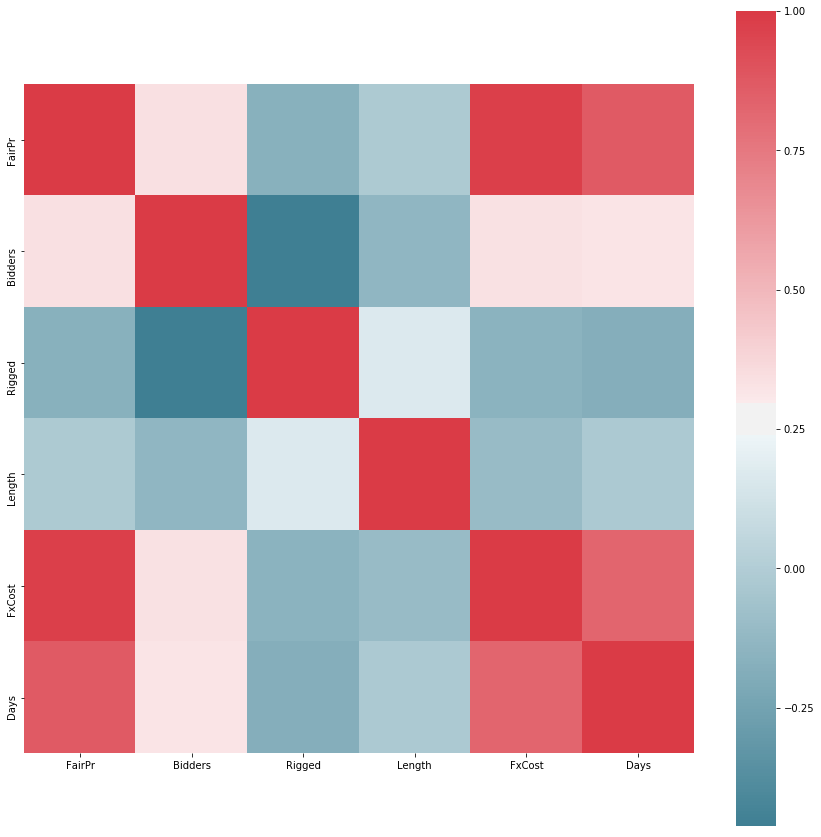

In [7]:
X = df[['FairPr', 'Bidders', 'Rigged', 'Length', 'FxCost', 'Days']]
f, ax = plt.subplots(figsize=(15, 15))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Strong correlation between variables: "FairPr"- "Days" and "FairPr"- "FxCost" is observed. 
<BR> In general strong correlation between two variables included in a model has a negative impact on accuracy of estimated coefficients and may lead to their complete distraction. Common practise is to remove one of highly correlated variables from a model. However, on the purpose of this exercise, given this specific instruction and questions, both variables will be kept in the model. 

## MODEL 1

Fit a regression model to the data, with the dependent variable Ratio, computed as the ratio of Price to FairPr, against the explanatory variables FairPr, Bidders, Rigged, Length, FxCost, and Days. Examine whether there is curvature or heteroskedasticity problem. Help Bob answer the following questions based on this regression.

* FITTING A REGRESSION MODEL

In [8]:
results = smf.ols('Ratio ~ FairPr + Bidders + Rigged + Length + FxCost + Days', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     15.48
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           3.04e-13
Time:                        16:05:27   Log-Likelihood:                 106.50
No. Observations:                 133   AIC:                            -199.0
Df Residuals:                     126   BIC:                            -178.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9192      0.029     31.638      0.0

* MULTICOLLINEARITY

In [9]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
lzip(X.columns, vif)

[('FairPr', 77.30138244893712),
 ('Bidders', 2.586880559860412),
 ('Rigged', 1.3403498715266824),
 ('Length', 2.5203119782872654),
 ('FxCost', 53.90230996264113),
 ('Days', 9.11122708185233)]

To detect multicollinearity Variance Inflation Factor was used (VIF). It is deemed that if a VIF is greater than 10, high multicollinearity occurs and the factor will appear to be more influential than it really is. As indicated in the table above, we can observe VIF higher than 10 for 2 variables: "FairPr" and "FxCost". For variable "Days" VIF value is also almost close to 10. It should be noted that all of those 3 variables are variables between which strong correlation was observed. For this model it is recommended to apply methods that can be used to reduce high VIFs, that is to reduce multicollinearity that occurs in this model. However, as mentioned before, on the purpose of this exercise, given this specific instruction and questions, all variables will be kept in the model. 

* FUNCTIONAL FORM OF A MODEL

In [10]:
# source: https://www.statsmodels.org/dev/_modules/statsmodels/stats/outliers_influence.html

def reset_ramsey(res, degree=5):
    '''Ramsey's RESET specification test for linear models

    This is a general specification test, for additional non-linear effects
    in a model.


    Notes
    -----
    The test fits an auxiliary OLS regression where the design matrix, exog,
    is augmented by powers 2 to degree of the fitted values. Then it performs
    an F-test whether these additional terms are significant.

    If the p-value of the f-test is below a threshold, e.g. 0.1, then this
    indicates that there might be additional non-linear effects in the model
    and that the linear model is mis-specified.


    References
    ----------
    http://en.wikipedia.org/wiki/Ramsey_RESET_test

    '''
    order = degree + 1
    k_vars = res.model.exog.shape[1]
    #vander without constant and x:
    y_fitted_vander = np.vander(res.fittedvalues, order)[:, :-2] #drop constant
    exog = np.column_stack((res.model.exog, y_fitted_vander))
    res_aux = OLS(res.model.endog, exog).fit()
    #r_matrix = np.eye(degree, exog.shape[1], k_vars)
    r_matrix = np.eye(degree-1, exog.shape[1], k_vars)
    #df1 = degree - 1
    #df2 = exog.shape[0] - degree - res.df_model  (without constant)
    return res_aux.f_test(r_matrix) #, r_matrix, res_aux

In [11]:
name = ['t value', 'p value']
test = reset_ramsey(results)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.47498008]]), p=0.7540258334875081, df_denom=122, df_num=4>

Ramsey RESET Test
<br> H_0: correct specification of the model
<br> H_1: the model suffers from misspecification
<br> RESET = 0.754 > 0.05 => no reason to reject null hyphothesis
<br> The functional form of a model is correctly specified.

* NORMALITY OF THE RESIDUALS

Jarque-Bera Test
<br> H_0: residuals have a normal distribution
<br> H_1: residuals do not have a normal distribution
<br> JB = 0.817 > 0.05 => no reason to reject null hyphothesis
<br> Residuals have a normal distribution.

* HETEROSKEDASTICITY

In [12]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 4.284121414130722),
 ('p-value', 0.6382871372608576),
 ('f-value', 0.6989545554531295),
 ('f p-value', 0.6509261255146672)]

Breush-Pagan test
<br> H_0: homoskedasticity
<br> H_1: heteroskedasticity
BP = 0.638 > 0.05 => no reason to reject null hyphothesis
<br> The problem of heteroskedasticity does not occure in this model. 


#### (i) Give your best estimate and a 90% confidence interval of what will happen to the ratio of the actual price to the estimated cost if the number of days for a project decreases by 250, holding the other independent variables fixed.

In [13]:
days_change = -250

mean = results.params.loc['Days'] * days_change
interval = results.conf_int(alpha=0.1).loc['Days'] * days_change

lzip(['Mean', '10% CI LB', '10% CI UB'],
     [mean, interval[0], interval[1]])

[('Mean', -0.05192376436139343),
 ('10% CI LB', -0.0013895012892829613),
 ('10% CI UB', -0.1024580274335039)]

#### (ii) Can you claim at the usual 5% significance level that an increase in the number of bidders, holding the other independent variables fixed, will on average decrease the ratio of the price of a project relative to the ODOT estimate?

Analyzing table "OLS Regression Results" and values of P>|t| for each coefficient, assuming 5% level of significance, we are NOT in a position to claim that increasing the number of bidders will decrease the ratio. (p-value of Bidders: 0.063 > 0.05)

#### (iii) Would it be legitimate, at the usual 5% significance level, to drop the variables FairPr and FxCost out of the regression, if you wanted to do so? If the answer is yes, write down the new estimated regression equation.

Analyzing table "OLS Regression Results" and values of P>|t| for each coefficient, assuming 5% level of significance, we are in a position to claim that variables FairPr and FxCost are not statistically significant so we can drop the out of the regression. (p-value of FairPr: 0.278 > 0.05 ; p-value of FxCost: 0.382 > 0.05)

In [14]:
results1 = smf.ols('Ratio ~ Bidders + Rigged + Length + Days', data=df).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     22.91
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           2.73e-14
Time:                        16:05:27   Log-Likelihood:                 105.68
No. Observations:                 133   AIC:                            -201.4
Df Residuals:                     128   BIC:                            -186.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9273      0.028     33.396      0.0

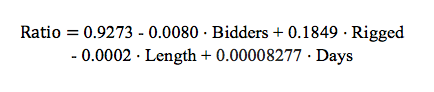

In [15]:
Image("images/img1.png")

(iv) One of your colleagues, Stan, draws your attention to a potential problem in the regression. He claims, “Almost all of the jobs the attorney general classified as rigged took place during the hot summer months. Everyone knows that jobs in the hot weather are harder to do, and therefore command a greater premium over estimated costs than jobs done at other times of the year.”

#### (a) If Stan is right then what is wrong with the regression?

If Stan is right, it means that the current regression model overestimates the influence of a job classified as rigged on the price. Assuming that if when a job is classified as rigged it is also usually done during the hot summer months and assuming that hot weather has a positive influence on the price, the current model's "Rigged" coefficient actually partly captures the effect of the hot weather and attributes it to a technaclly wrong cause.

#### (b) Suppose you can gather data regarding the time of year each job took place and use it to create a new variable, HOT (= 1 if the job took place during the hot summer months and = 0 otherwise). If Stan is right, what will change (and how) when you include HOT as an additional independent variable in the regression?

After the introduction of the HOT variable, assuming that "Rigged" usually equals 1 whenever "HOT" equals 1 (as Stan claims), the effect (coefficient) of the "Rigged" variable on the price will decrease and the regression model will assign a positive coefficient to the "HOT" variable which now captures the effect of hot weather on the price. However, the higher the correlation between the two variables, the lower the precision of the assignmenet of the effect to the two variables.

In the example below, "Rigged" and "HOT" have a correlation of 1 (100%). The resulting regression model assigns both variables exactly half the size of the previous coefficient of "Rigged".

In [16]:
df['HOT'] = df['Rigged']
results_hot = smf.ols('Ratio ~ Bidders + Rigged + HOT + Length + Days', data=df).fit()
print(results_hot.summary())

                            OLS Regression Results                            
Dep. Variable:                  Ratio   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     22.91
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           2.73e-14
Time:                        16:05:27   Log-Likelihood:                 105.68
No. Observations:                 133   AIC:                            -201.4
Df Residuals:                     128   BIC:                            -186.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9273      0.028     33.396      0.0

## MODEL 2a

For answering following, you must build your own regression models, if necessary. Remember to check the soundness of your specifications (linearity and homoskedasticity). Use a significance level of at least 20% when deciding to drop variable(s).
<BR> Develop a sound regression model to estimate and predict the winning bid (Price) on the final contract for 2018, which has the characteristics below.
<br> • The estimated cost is 10,000,000, of which 7,000,000 is due to fixed costs.
<br> • The 4 contractors interested in the project are expected not to rig the auction.

* FITTING A REGRESSION MODEL

In [17]:
results2 = smf.ols('Price ~ FairPr + Bidders + Rigged + FxCost', data=df).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     973.5
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           9.44e-95
Time:                        16:05:27   Log-Likelihood:                -931.11
No. Observations:                 133   AIC:                             1872.
Df Residuals:                     128   BIC:                             1887.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.9664     64.099      1.466      0.1

Analyzing table "OLS Regression Results" and values of P>|t| for each coefficient, assuming 20% level of significance, we are in a position to claim that variable FxCost is not statistically significant so we can drop the out of the regression. (p-value of FxCost: 0.394 > 0.2) The variable was dropped and a new model was estimated.

In [18]:
results3 = smf.ols('Price ~ FairPr + Bidders + Rigged', data=df).fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1301.
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           3.47e-96
Time:                        16:05:27   Log-Likelihood:                -931.49
No. Observations:                 133   AIC:                             1871.
Df Residuals:                     129   BIC:                             1883.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.4696     61.421      1.278      0.2

* MULTICOLLINEARITY

In [19]:
X_1 = df[['FairPr', 'Bidders', 'Rigged']]

In [20]:
vif = [variance_inflation_factor(X_1.values, i) for i in range(X_1.shape[1])]
lzip(X_1.columns, vif)

[('FairPr', 1.6123719489065504),
 ('Bidders', 1.6841488442073644),
 ('Rigged', 1.0739000919206745)]

Analyzing values of Variance Inflation Factors for all variables included in the model, we are in a position to claim that the problem of multicollinearity does not occure in this model. 

* FUNCTIONAL FORM OF A MODEL

In [21]:
name = ['t value', 'p value']
test = reset_ramsey(results3)
test

C:\Users\nicol\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[722.18036008]]), p=8.661851516703509e-71, df_denom=129, df_num=2>

Ramsey RESET Test
<br> H_0: correct specification of the model
<br> H_1: the model suffers from misspecification
<br> RESET = 7.24548266486042e-103 < 0.05 => there is a reason to reject null hyphothesis
<br> The model suffers from misspecification.

* NORMALITY OF THE RESIDUALS

Jarque-Bera Test
<br> H_0: residuals have a normal distribution
<br> H_1: residuals do not have a normal distribution
<br> JB = 0.00 > 0.05 => there is a reason to reject null hyphothesis
<br> Residuals do not have a normal distribution

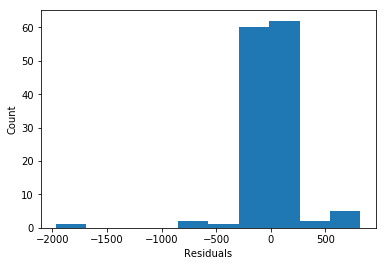

In [22]:
plt.hist(results3.resid)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

* HETEROSKEDASTICITY

In [23]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results3.resid, results3.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 47.30678503749735),
 ('p-value', 2.990676834816012e-10),
 ('f-value', 23.73807258255512),
 ('f p-value', 2.6778341249089585e-12)]

Breush-Pagan test
<br> H_0: homoskedasticity
<br> H_1: heteroskedasticity
BP = 2.990676834816012e-10 < 0.05 => there is a reason to reject null hyphothesis
<br> The problem of heteroskedasticity occures in this model. 

## MODEL 2b

Taking into consideration results of tests checking functional form of a model, normality of its residuals and its heteroskedasticity, we decided to reevaluate a functional form of the model. As far as meeting an assumption of a normal distribution of residuals is desirable however not mandatory, using OLS method for regression requires a condition of homoskedastic residuals to be met. 

* FITTING A REGRESSION MODEL

The method we decided to use to fix a problem with both- non normal distribution of residuals and its heteroskedasticity, is an adoption of logaritms of non binary variables that do not meet an assumption of a normal distribution of its own.

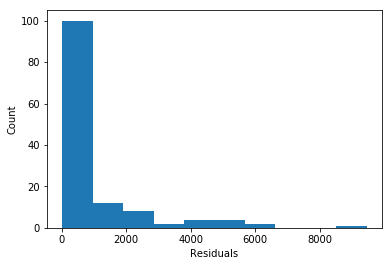

In [24]:
plt.hist(df.Price)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

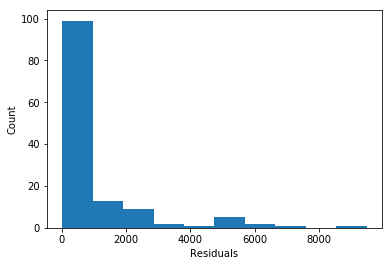

In [25]:
plt.hist(df.FairPr)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

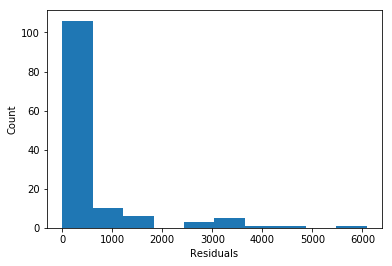

In [26]:
plt.hist(df.FxCost)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

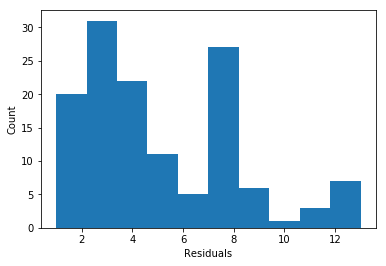

In [27]:
plt.hist(df.Bidders)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

In [28]:
df['logPrice']=np.log(df['Price'])
df['logFairPr']=np.log(df['FairPr'])
df['logFxCost']=np.log(df['FxCost'])
df['logBidders']=np.log(df['Bidders'])

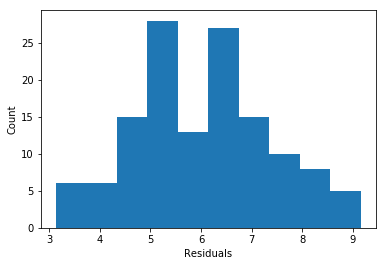

In [29]:
plt.hist(df.logPrice)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

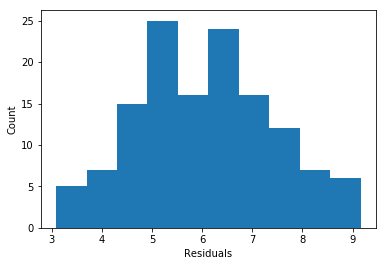

In [30]:
plt.hist(df.logFairPr)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

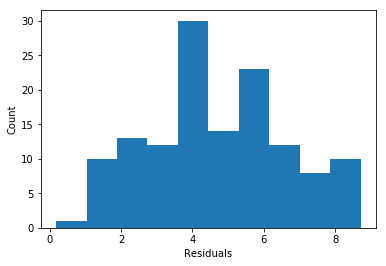

In [31]:
plt.hist(df.logFxCost)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

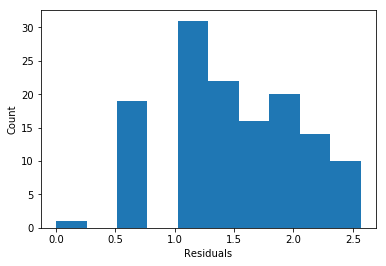

In [32]:
plt.hist(df.logBidders)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

In [33]:
results4 = smf.ols('logPrice ~ logFairPr + logBidders + Rigged + logFxCost', data=df).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3972.
Date:                Tue, 15 Jan 2019   Prob (F-statistic):          3.81e-133
Time:                        16:05:30   Log-Likelihood:                 92.598
No. Observations:                 133   AIC:                            -175.2
Df Residuals:                     128   BIC:                            -160.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0270      0.073     -0.370      0.7

Analyzing table "OLS Regression Results" and values of P>|t| for each coefficient, assuming 20% level of significance, we are in a position to claim that variable logFxCost is not statistically significant so we can drop the out of the regression. (p-value of logFxCost: 0.209 > 0.2) The variable was dropped and a new model was estimated.

In [34]:
results4 = smf.ols('logPrice ~ logFairPr + logBidders + Rigged', data=df).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:               logPrice   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5271.
Date:                Tue, 15 Jan 2019   Prob (F-statistic):          1.07e-134
Time:                        16:05:30   Log-Likelihood:                 91.774
No. Observations:                 133   AIC:                            -175.5
Df Residuals:                     129   BIC:                            -164.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0880      0.055     -1.608      0.1

* MULTICOLLINEARITY

In [35]:
X_2 = df[['logFairPr', 'logBidders', 'Rigged']]

In [36]:
vif = [variance_inflation_factor(X_2.values, i) for i in range(X_2.shape[1])]
lzip(X_2.columns, vif)

[('logFairPr', 13.220407058623985),
 ('logBidders', 11.308092687222954),
 ('Rigged', 1.6360674797789685)]

* FUNCTIONAL FORM OF A MODEL

In [37]:
name = ['t value', 'p value']
test = reset_ramsey(results4)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.84061111]]), p=0.5019290804144619, df_denom=125, df_num=4>

Ramsey RESET Test
<br> H_0: correct specification of the model
<br> H_1: the model suffers from misspecification
<br> RESET = 0.5019290771502827 > 0.05 => there is no reason to reject null hyphothesis
<br> The model is correctly specified.

* NORMALITY OF THE RESIDUALS

Jarque-Bera Test
<br> H_0: residuals have a normal distribution
<br> H_1: residuals do not have a normal distribution
<br> JB = 0.0249 > 0.05 => there is a reason to reject null hyphothesis
<br> Residuals do not have a normal distribution.

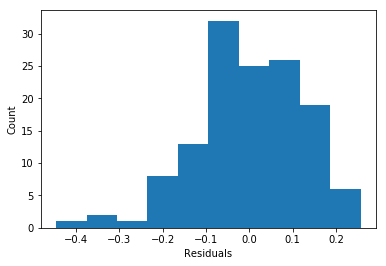

In [38]:
plt.hist(results4.resid)
plt.ylabel('Count')
plt.xlabel('Residuals')
plt.show()

<br> Assumption of Normal Distribution of Residuals does not have to be met. According to Gauss-Markov Theorem Least Squares Regression is the BLUE estimator regardless of it. A normal distribution is only used to show that the estimator is also the Maximum Likelihood Estimator. 

* HETEROSKEDASTICITY

In [39]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results4.resid, results4.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 3.1391939447323867),
 ('p-value', 0.3706581033834159),
 ('f-value', 1.0394617415669198),
 ('f p-value', 0.377481863125743)]

Breush-Pagan test
<br> H_0: homoskedasticity
<br> H_1: heteroskedasticity
<br> BP = 0.3706581033834159 > 0.05 => there is no reason to reject null hyphothesis
<br> The problem of heteroskedasticity does not occure in this model. 

#### (a) Write down the estimated regression equation and explain how you came to choose it.

WE HAVE TO PUT HERE A PHOTO OF AN EQUATION ONCE WE FIGURE OUT THE FINAL MODEL (MULTICOLLINEARITY!!!)

The process of creating a model was described step by step on each stage of its development. Below we present a short summary.
<BR> Taking into consideration results of tests checking functional form of a primary model 2a, normality of its residuals and its heteroskedasticity, we decided to reevaluate a functional form of the model. As far as meeting an assumption of a normal distribution of residuals is desirable however not mandatory, using OLS method for regression requires a condition of homoskedastic residuals to be met. 
<BR> The method we decided to use to fix a problem with both- non normal distribution of residuals and its heteroskedasticity, is an adoption of logaritms of non binary variables that do not meet an assumption of a normal distribution of its own, that is "Price", "FairPr", "Bidders" and "FxCost". Thereafter variable "logFxCost" was dropped due to it's lack of statistical sigifficance at the level of 20%. 
<BR> Results of Breush- Pagan test confirmed that the problem of heteroskedasticity does no longer occure in this model. Residuals still do not have a normal distribution however, as mentioned above, assumption of Normal Distribution of Residuals does not have to be met. According to Gauss-Markov Theorem Least Squares Regression is the BLUE estimator regardless of it. A normal distribution is only used to show that the estimator is also the Maximum Likelihood Estimator. 

#### (b) Give a point estimate for the winning bid and provide an interval that will contain the winning bid with 90% confidence.

In [40]:
# log-transforming the data

fairpr = 1000
fxcost = 700
bidders = 4
rigged = 0

log_fairpr = np.log(fairpr)
log_fxcost = np.log(fxcost)
log_bidders = np.log(bidders)

log_bet = pd.Series({'logFairPr': log_fairpr,
                     'logFxCost': log_fxcost,
                     'logBidders': log_bidders,
                     'Rigged': rigged})

In [42]:
log_pred = results4.get_prediction(log_bet)
log_mean = log_pred.predicted_mean[0]
log_interval = log_pred.conf_int(alpha=0.1, obs=True)[0]

mean = np.exp(log_mean)
interval = np.exp(log_interval)

lzip(['Mean', '10% CI LB', '10% CI UB'],
     [mean, interval[0], interval[1]])

[('Mean', 901.6941606037242),
 ('10% CI LB', 733.8246742849649),
 ('10% CI UB', 1107.9654142988434)]

#### (c) How confident are you that in this project the winning bid will come in “under budget” (so that Bob will earn his bonus)?

In [65]:
# log-transforming the data

ub = 1107
log_ub = np.log(ub)

In [66]:
log_se = log_pred.se_obs[0]

q = (log_ub - log_mean)/log_se
conf = stats.t.cdf(q, log_pred.df)
"Confidence", conf

('Confidence', 0.949285567322308)

We are confident that the winning bid will come in "under budget" at a confidence level of 52.93%.

## MODEL 4

ODOT has a road reconstruction project that is in the early planning phase. Just before putting the job up for auction, it is learnt that building an additional pedestrian bridge will be necessary as part of the project. This change will not affect the duration of the job or the length of the road, but it will increase fixed costs (FxCost) by 15% and overall estimated costs (FairPr) by 5%.
<BR> ODOT hasn’t put the project up for bidding yet, and your goal is to estimate the percentage increase in the winning bid (the Price of the contract) that will ultimately result from the change in projected costs.

#### (a) What regression would you use to estimate the increase in Price? Write down the estimated regression equation, and explain how you arrived at that regression.


#### (b) Using your regression in part (a), what is your estimate for the percentage increase in the Price of this contract?